In [1]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


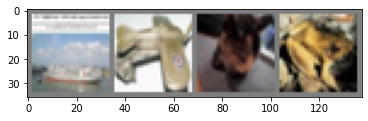

 ship plane   cat  frog


In [2]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F
# define the CNN architecture

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
        # dropout
        self.dropout = nn.Dropout(p=.5)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flattening
        x = x.view(-1, 64 * 4 * 4)
        # fully connected layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x
# create a complete CNN
model = Net()
print(model)


Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

model.to(device)
print(model.conv1.bias.get_device())

cpu
-1


In [6]:
import torch.optim as optim
# specify loss function
criterion = nn.CrossEntropyLoss()
# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=.01)

In [10]:
epoch_num = 5

for epoch in range(epoch_num):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    

print('Finished Training')


[1,  2000] loss: 0.931
[1,  4000] loss: 0.961
[1,  6000] loss: 0.959
[1,  8000] loss: 0.965
[1, 10000] loss: 0.953
[1, 12000] loss: 0.944
[2,  2000] loss: 0.865
[2,  4000] loss: 0.896
[2,  6000] loss: 0.895
[2,  8000] loss: 0.881
[2, 10000] loss: 0.906
[2, 12000] loss: 0.922
[3,  2000] loss: 0.804
[3,  4000] loss: 0.846
[3,  6000] loss: 0.844
[3,  8000] loss: 0.860
[3, 10000] loss: 0.860
[3, 12000] loss: 0.842
[4,  2000] loss: 0.785
[4,  4000] loss: 0.796
[4,  6000] loss: 0.811
[4,  8000] loss: 0.814
[4, 10000] loss: 0.802
[4, 12000] loss: 0.840
[5,  2000] loss: 0.743
[5,  4000] loss: 0.767
[5,  6000] loss: 0.770
[5,  8000] loss: 0.764
[5, 10000] loss: 0.823
[5, 12000] loss: 0.777
Finished Training


In [8]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 63 %


In [9]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 59 %
Accuracy of   car : 80 %
Accuracy of  bird : 43 %
Accuracy of   cat : 50 %
Accuracy of  deer : 50 %
Accuracy of   dog : 59 %
Accuracy of  frog : 68 %
Accuracy of horse : 71 %
Accuracy of  ship : 73 %
Accuracy of truck : 68 %
